
### SYSTEMATIC TAA - EcoTrend - US - Composite Model

- **Model:**
	- Composite model of EcoTrend strategies:
		- OECD diffusion-model: if % countries with rising oecd > 50%: invest in SP500, Tbills otherwise.
		- Lei-model: if economic impulse strong or negative but recovering: invest in SP500, Tbills otherwise
		- US oecd-model: if short-term change in US OECD is positive: invest in SP500, momentum mode otherwise:SP500 or Tbills
		- Yield curve-mode: if % of curves inverted < 20%: invest in SP500, momentum mode otherwise: Treasuries or Tbills
		- Sahm-model: if unemployment < 0.5% of 12m-low in U3: invest in SP500, momentum mode otherwise: SP500, Treasuries or Tbills
- **Trading frequency:** monthly
- **Time Period studied:** 1960 - now
- **Data:**
    - return series from the individual models read from CSV file
- **Simple rules:**
    - Equal weight strategy of 20% in each strategy.
    - Each strategy is either invested in the S&P500 during the risk-on signal (economic signal). 
    - During the risk-off signal (based on economic signal):
     	- Some strategies immediately switch to Tbills: oecd diffusion model & US Lei model
    	- Other strategies switch to momentum mode choosing an asset class with the strongest momentum based on a composite momentum 
    	 score over the past 12m,6m,3m and 1m.
- **Trading costs and slippage:**
	- 20 bps transaction cost per trade
- **Findings**:
    - Any mistakes remain mine. If you find any, please do let me know so I can rectify. Thank you!
    - Risk-adjusted return metrics approve for the composite model versus individual models. Max drawdown improve as well.
    - The composite model reaches a sharpe and Sortino of respectively 0.45 and 0.65 versus 0.26 and 0.38 for a hard-to-beat 60/40 benchmark. The 62-year backtest does not take into account dividends and trades on a 20 bps transaction cost. With dividends, sharpe and sortino would be near 0.65 and 0.9.
- **Future tests**:
	- Add non-economic long only models to this long only composite strategy: cross-asset momentum, global equity index trend, carry and value. Add other regions to it to diversify further.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import scipy.stats as ss
#import empiricaldist as emp
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
#FUNCTIONS USED IN NOTEBOOK

def duration(c, y, m, n):
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y) )
    modified_duration = macaulay_duration / (1 + y)
    return macaulay_duration


def mom_score(r):
    """"Calculates a composite momentum score for a return series over 12,3,6 and 1 month with weights"
    Args:
        r(pd.Series): the Return series in R format
    Returns:
        pd.Series:composite momentum score
     """
    ret1M=r
    ret3M=(r+1).rolling(3).apply(np.prod)-1
    ret6M=(r+1).rolling(6).apply(np.prod)-1
    ret12M=(r+1).rolling(12).apply(np.prod)-1
    mom=0.4*ret1M+0.3*ret3M+0.2*ret6M+0.1*ret12M
    return mom

def annualized_return(r,per):
    """ Annualized return calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (eg:0.005=0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized return
    """
    YearFraq=r.shape[0]/per
    Index=(1+r).cumprod()
    annual_return=(Index[-1]-1)**(1/YearFraq)-1
    return annual_return  

def annualized_vol(r,per):
    """ Annualized volatility calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    annual_vol=r.std()*np.sqrt(per)
    return annual_vol

def downside_vol(r,per):
    """ Annualized volatility of the negative returns calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    down_vol=r[r<0].std()*np.sqrt(per)
    return down_vol

def sharpe_ratio(r1,r2,per):
    """ Sharpe ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_volatility=annualized_vol(r1,per)
    sharpe=(strategy_return-risk_free_return)/strategy_volatility
    
    return sharpe

def sortino_ratio(r1,r2,per):
    """ Sortino ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_downside_volatility=downside_vol(r1,per)
    sortino=(strategy_return-risk_free_return)/strategy_downside_volatility
    
    return sortino

  


def tracking_error(r1,r2,per):
    """ Annualized tracking error calculated from 2 return series.
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized tracking error
    """
    excess_ret=r1-r2
    track_error=excess_ret.std()*np.sqrt(12)
    return track_error

def information_ratio(r1,r2,per):
    """ Calculates the information ratio of a strategy based on return series strategy, return series benchmark 
    and period adjustment factor to annualized volatlity.
    ir= (annual return strategy - annual return bench)/tracking error
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: information ratio
    """
    annual_return_strategy=annualized_return(r1,per)
    annual_return_benchmark=annualized_return(r2,per)
    track_error=tracking_error(r1,r2,per)
    ir = (annual_return_strategy-annual_return_benchmark)/track_error
    return ir


#function to style a dataframe that shows returns in pivot form
def style_df(df_):
    def style_negative(v, props=''):
        return props if v < 0 else None
    
    cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#7FB3D5")]
    }
    index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: white"
    }
    headers = {
    "selector": "th",
    "props": "background-color: #273746; color: white"
    }
    cells = {
    "selector": "td",
    "props": "background-color: white; font-size: 13px;font-family: sans-serif;border-collapse:collapse; border: 1px solid"
    }  
    x=df_.style\
        .applymap(style_negative, props='color:red;')\
        .format(formatter='{:,.2f}%',na_rep='-')\
        .set_table_styles([cell_hover,index_names, headers,cells])
    return x          

[*********************100%***********************]  1 of 1 completed


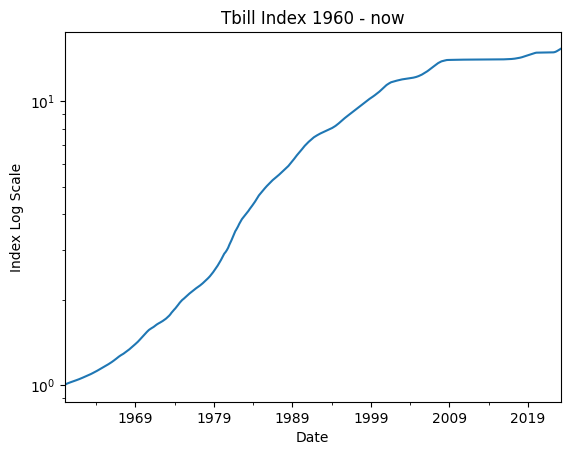

Date
1960-01-31    0.003460
1960-02-29    0.002993
1960-03-31    0.003030
1960-04-30    0.002563
1960-05-31    0.002744
Freq: M, Name: tbill_tr, dtype: float64

In [3]:
#Import Tbill data and calculate monthly returns
start='1950-01-31'
tbill_d=yf.download("^IRX",start)['Adj Close']
tbill_dr=tbill_d/100/252+1
tbill_series=tbill_dr.resample('M').prod()-1
tbill_series.name='tbill_tr'

#Tbill Chart
(tbill_series+1).cumprod().plot(logy=True)
plt.title('Tbill Index 1960 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
tbill_series.head()

[*********************100%***********************]  1 of 1 completed


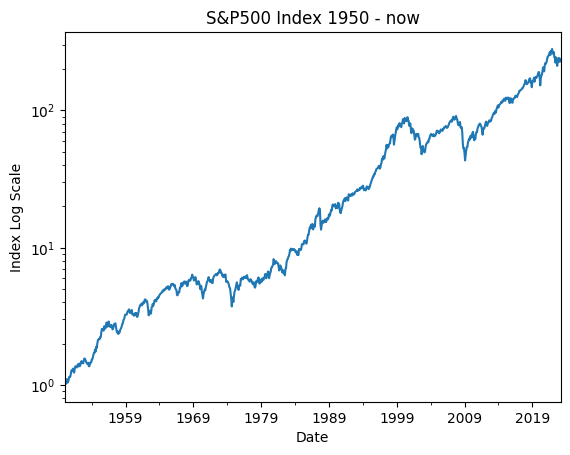

Date
1950-01-31    0.000000
1950-02-28    0.009971
1950-03-31    0.004065
1950-04-30    0.038751
1950-05-31    0.045657
Freq: M, Name: sp500_tr, dtype: float64

In [4]:
#Download S&P500 price data from Yahoo Finance
sp500_series=yf.download("^GSPC","1950-01-31")['Adj Close'].pct_change()+1
sp500_series=sp500_series.resample('M').prod()-1
sp500_series.name='sp500_tr'

#S&P500 Chart
(sp500_series+1).cumprod().plot(logy=True)
plt.title('S&P500 Index 1950 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
sp500_series.head()

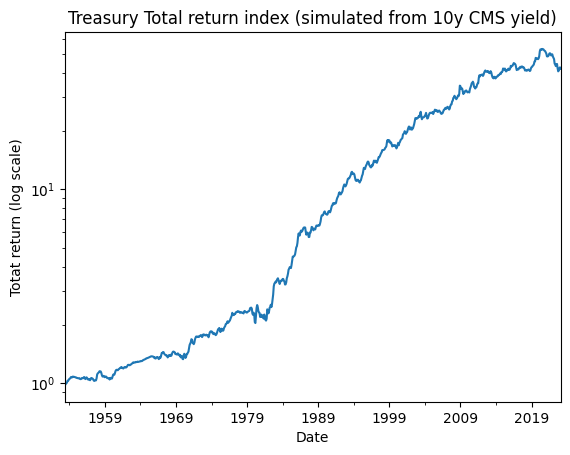

,treasury_yield,yield_chg,dur,treasury_tr
Date,,,,
1953-05-31,0.0305,0.0022,8.767986,-0.016748
1953-06-30,0.0311,0.0006,8.746322,-0.002656
1953-07-31,0.0293,-0.0018,8.811587,0.018303
1953-08-31,0.0295,0.0002,8.804295,0.000697
1953-09-30,0.0287,-0.0008,8.833525,0.009458


In [5]:
#Download Treasury Yield data from NasdaqLink
url_ty='https://data.nasdaq.com/api/v3/datasets/FED/RIFLGFCY10_N_M.csv?api_key=5VHLVjsL1zzxZ77rMAD4'
custom_date_parser=lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
treasury=pd.read_csv(url_ty,index_col='Date',parse_dates=True,date_parser=custom_date_parser)
treasury.sort_index(inplace=True)
treasury=treasury.resample('M').last()
treasury.columns=['treasury_yield']
treasury['treasury_yield']=treasury['treasury_yield']/100

#Calculate a monthly Treasury total return value using yield as coupon and duration function. Should add convexity!
treasury['yield_chg']=treasury['treasury_yield'].diff()
treasury['dur']=duration(treasury['treasury_yield'].values,treasury['treasury_yield'].values,1,10)
treasury['treasury_tr']=treasury['treasury_yield']/12-(treasury['yield_chg']*treasury['dur'])
treasury.dropna(inplace=True)

#Treasury Chart
(treasury['treasury_tr']+1).cumprod().plot(logy=True)
plt.title('Treasury Total return index (simulated from 10y CMS yield)')
plt.ylabel('Totat return (log scale)')
plt.show()
treasury.head()

In [6]:
#import the series from csv-files in directory
lei_series=pd.read_csv('lei_return.csv',index_col='date',parse_dates=True)
oecd_diffusion_series= pd.read_csv('oecd_diffusion_return.csv',index_col='date',parse_dates=True)
oecd_series=pd.read_csv('oecd_return.csv',index_col='date',parse_dates=True)
sahm_series=pd.read_csv('sahm_return.csv',index_col='date',parse_dates=True)
yield_curve_series=pd.read_csv('yield_curve_return.csv',index_col='date',parse_dates=True)

#concat them all
strat_df=pd.concat([lei_series,oecd_diffusion_series,oecd_series,sahm_series,yield_curve_series],axis=1)
strat_df=strat_df['1955-12':]
strat_df.index.rename('Date',inplace=True)

In [7]:
#Add financial series to the strat_df
strat_df=pd.concat([strat_df,sp500_series,tbill_series,treasury['treasury_tr']],axis=1)
strat_df=strat_df['1960-1':]
strat_df=strat_df[:-1]



In [8]:

#Create '60/40 returns
strat_df['bench_tr']=0.6*strat_df['sp500_tr']+0.4*strat_df['treasury_tr']


#Calculate net returns of equal weighted composite model
strat_df['strat_nr']=strat_df.iloc[:,:5].mean(axis=1)
strat_df


,lei_return,oecd_diffusion_return,oecd_return,sahm_return,yield_curve_return,sp500_tr,tbill_tr,treasury_tr,bench_tr,strat_nr
Date,,,,,,,,,,
1960-01-31,-0.001558,NaN,-0.027458,NaN,NaN,-0.071464,0.003460,0.001474,-0.042289,-0.014508
1960-02-29,0.004125,0.000987,0.000000,NaN,NaN,0.009171,0.002993,0.022767,0.014610,0.001704
1960-03-31,-0.013899,-0.015871,0.000000,NaN,NaN,-0.013899,0.003030,0.023585,0.001095,-0.009923
1960-04-30,-0.017528,0.000558,0.000000,NaN,NaN,-0.017528,0.002563,0.001064,-0.010091,-0.005657
1960-05-31,0.026853,0.002744,0.000000,NaN,NaN,0.026853,0.002744,-0.002198,0.015233,0.009866
...,...,...,...,...,...,...,...,...,...,...
2022-10-31,0.003043,0.003043,0.000000,0.079863,0.003043,0.079863,0.003043,-0.035517,0.033711,0.017799
2022-11-30,0.003431,0.003431,0.000000,0.053753,0.003431,0.053753,0.003431,0.010867,0.036599,0.012809
2022-12-31,0.003513,0.003513,0.000000,-0.058971,0.003513,-0.058971,0.003513,0.026144,-0.024925,-0.009686


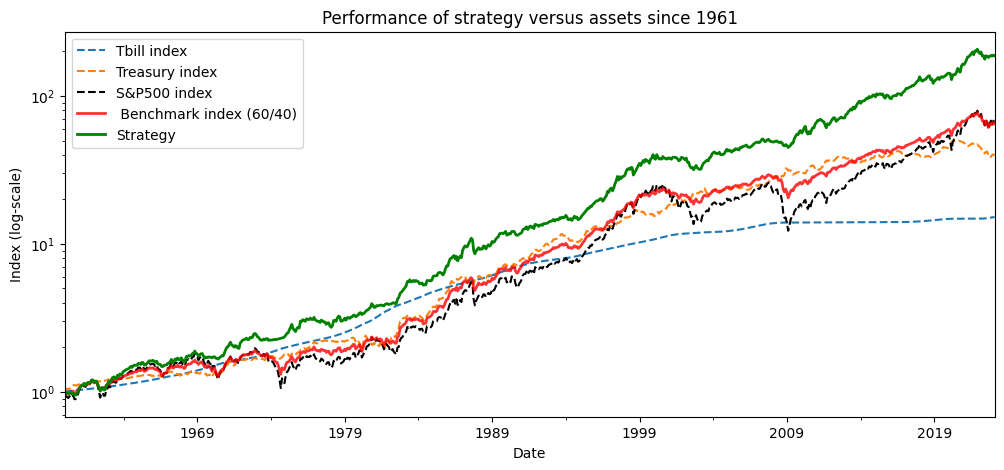

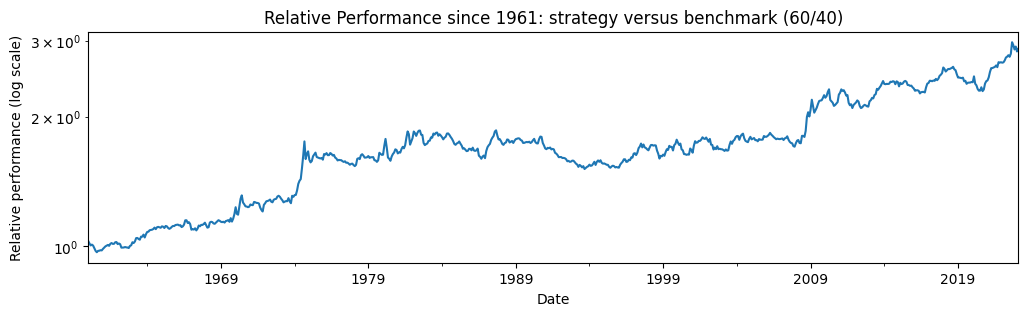

In [9]:
#Build wealth indices for comparison purposes
strat_df['tbill_index']=(strat_df['tbill_tr']+1).cumprod()
strat_df['treasury_index']=(strat_df['treasury_tr']+1).cumprod()
strat_df['sp500_index']=(strat_df['sp500_tr']+1).cumprod()
strat_df['bench_index']=(strat_df['bench_tr']+1).cumprod()
strat_df['strat_index']=(strat_df['strat_nr']+1).cumprod()

#plot the assets and strategy
strat_df['tbill_index'].plot(logy=True,label='Tbill index',figsize=(12,5),linestyle='--')
strat_df['treasury_index'].plot(logy=True,label='Treasury index',linestyle='--')
strat_df['sp500_index'].plot(logy=True,label='S&P500 index',linestyle='--',color='black')
strat_df['bench_index'].plot(logy=True, label=' Benchmark index (60/40)',linewidth=2,color='red',alpha=0.8)
strat_df['strat_index'].plot(logy=True, label='Strategy',linewidth=2,color='green')
plt.title('Performance of strategy versus assets since 1961')
plt.xlabel('Date')
plt.ylabel('Index (log-scale)')
plt.legend()
plt.savefig('strategy_vs_assets.png')
plt.show()


#relative performance
strat_df['relative']=strat_df['strat_index']/strat_df['bench_index']
strat_df['relative'].plot(logy=True,figsize=(12,3))
plt.title('Relative Performance since 1961: strategy versus benchmark (60/40)')
plt.xlabel('Date')
plt.ylabel('Relative performance (log scale)')
plt.savefig('relative performance.png')
plt.show()


In [10]:
#PERFORMANCE METRICS STRATEGY AND BENCHMARK

#correlation between strategy and bench
cor=strat_df["strat_nr"].corr(strat_df['bench_tr'])



#Annualized Returns
risk_free_ar=annualized_return(strat_df['tbill_tr'],12)
sp500_ar=annualized_return(strat_df['sp500_tr'],12)
treasury_ar=annualized_return(strat_df['treasury_tr'],12)
bench_ar=annualized_return(strat_df['bench_tr'],12)
strat_ar=annualized_return(strat_df['strat_nr'],12)

#Best and worst period returns
strat_best=strat_df['strat_nr'].max()
strat_worst=strat_df['strat_nr'].min()
bench_best=strat_df['bench_tr'].max()
bench_worst=strat_df['bench_tr'].min()
#% profitable
strat_prof=(strat_df['strat_nr']>0).mean()
bench_prof=(strat_df['bench_tr']>0).mean()

#AnnualizedVol
strat_vol=annualized_vol(strat_df['strat_nr'],12)
bench_vol=annualized_vol(strat_df['bench_tr'],12)

#Annualized downside vol
strat_down_vol=downside_vol(strat_df['strat_nr'],12)
bench_down_vol=downside_vol(strat_df['bench_tr'],12)

#Sharpe
strat_sharpe=sharpe_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sharpe=sharpe_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Sortino
strat_sortino=sortino_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sortino=sortino_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Tracking error
strat_tracking_error=tracking_error(strat_df['strat_nr'],strat_df['bench_tr'],12)

#InformationRatio
strat_info_ratio=information_ratio(strat_df['strat_nr'],strat_df['bench_tr'],12)
#information_ratio=(strat_ar-bench_ar)/strat_tracking_error 

#skew of strategy and benchmark
strat_skew=ss.skew(strat_df['strat_nr'])
bench_skew=ss.skew(strat_df['bench_tr'])

#Excess kurtosis of strategy and benchmark
strat_kurt=ss.kurtosis(strat_df['strat_nr'])
bench_kurt=ss.kurtosis(strat_df['bench_tr'])

#Var of strategy and benchmark

strat_var99=np.quantile(strat_df['strat_nr'],q=0.01)
bench_var99=np.quantile(strat_df['bench_tr'],q=0.01)

#CVAR of strategy and benchmark
strat_cvar99=strat_df['strat_nr'][strat_df['strat_nr']<strat_var99].mean()
bench_cvar99=strat_df['bench_tr'][strat_df['bench_tr']<bench_var99].mean()

#Parametric Gaussian VAR
strat_pvar99=strat_ar+ss.norm.ppf(0.01)*strat_vol
bench_pvar99=bench_ar+ss.norm.ppf(0.01)*bench_vol

#Drawdowns Strategy
strat_max=strat_df['strat_index'].cummax()
strat_dd=strat_df['strat_index']/strat_max-1
#Drawdowns Bench
bench_max=strat_df['bench_index'].cummax()
bench_dd=strat_df['bench_index']/bench_max-1
#MaxDrawdown
strat_md=min(strat_dd)
bench_md=min(bench_dd)
#MAR since inception
strat_r_to_md=strat_ar/abs(strat_md)
bench_r_to_md=bench_ar/abs(bench_md)

In [11]:
#Put Everything in DataFrame
output_dict={'Performance Metrics':['Correlation with benchmark','CAGR%','Best month','Worst month','% profitable','Vol','Downside Vol','Sharpe Ratio','Sortino Ratio','Information Ratio','Tracking Error','Skewness','Excess Kurtosis','Historic Var (1%)','Historic Cvar (1%)','Gaussian Var (1%)','Max Drawdown %','MAR ratio'],
        'Strategy':['{:.2f}%'.format(cor*100),'{:.2f}%'.format(strat_ar*100),'{:.2f}%'.format(strat_best*100),'{:.2f}%'.format(strat_worst*100),'{:.2f}%'.format(strat_prof*100),'{:.2f}%'.format(strat_vol*100),'{:.2f}%'.format(strat_down_vol*100),'{:.2f}'.format(strat_sharpe),'{:.2f}'.format(strat_sortino),'{:.2f}'.format(strat_info_ratio),'{:.2f}%'.format(strat_tracking_error*100),'{:.2f}'.format(strat_skew),'{:.2f}'.format(strat_kurt),'{:.2f}%'.format(strat_var99*100),'{:.2f}%'.format(strat_cvar99*100),'{:.2f}%'.format(strat_pvar99*100),'{:.2f}%'.format(strat_md*100),'{:.2f}'.format(strat_r_to_md)],
        'Benchmark 60/40':['-','{:.2f}%'.format(bench_ar*100),'{:.2f}%'.format(bench_best*100),'{:.2f}%'.format(bench_worst*100),'{:.2f}%'.format(bench_prof*100),'{:.2f}%'.format(bench_vol*100),'{:.2f}%'.format(bench_down_vol*100),'{:.2f}'.format(bench_sharpe),'{:.2f}'.format(bench_sortino),'-','-','{:.2f}'.format(bench_skew),'{:.2f}'.format(bench_kurt),'{:.2f}%'.format(bench_var99*100),'{:.2f}%'.format(bench_cvar99*100),'{:.2f}%'.format(bench_pvar99*100),'{:.2f}%'.format(bench_md*100),'{:.2f}'.format(bench_r_to_md)]
}
start=strat_df.index[0].strftime("%Y-%m")
end = strat_df.index[-1].strftime("%Y-%m")

metrics=pd.DataFrame(output_dict)
metrics=metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
metrics




,Performance Metrics ( 1960-01 till 2023-02),Strategy,Benchmark 60/40
0,Correlation with benchmark,85.71%,-
1,CAGR%,8.63%,6.81%
2,Best month,12.42%,10.74%
3,Worst month,-15.34%,-13.02%
4,% profitable,61.48%,61.21%
5,Vol,10.06%,9.72%
6,Downside Vol,6.61%,6.56%
7,Sharpe Ratio,0.43,0.26
8,Sortino Ratio,0.66,0.38
9,Information Ratio,0.34,-


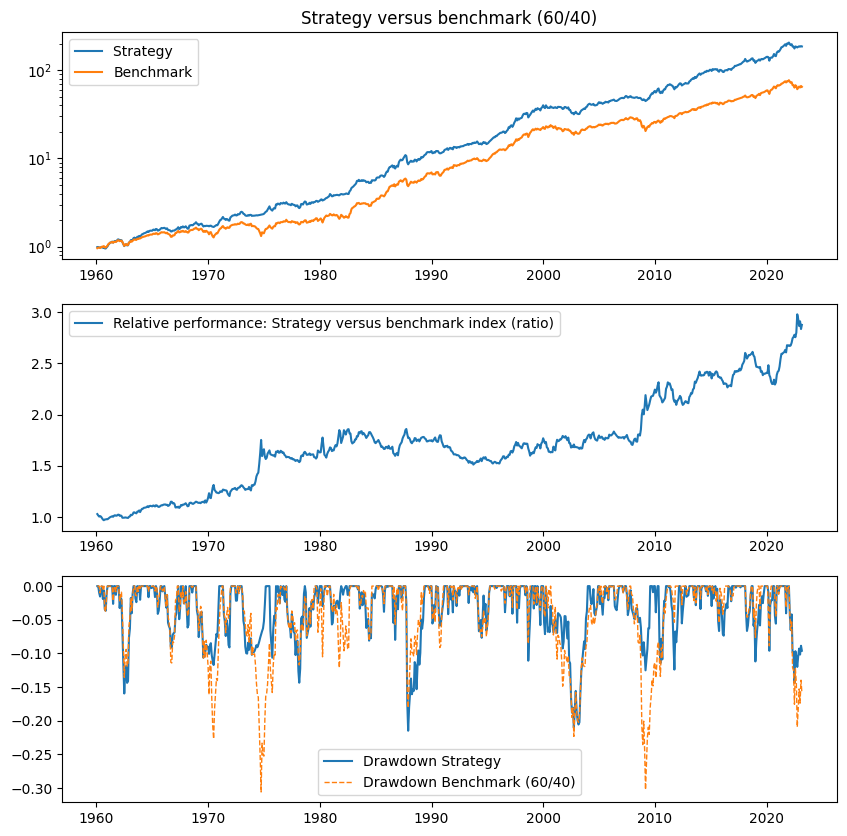

In [12]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Strategy versus benchmark (60/40)")
ax[0].semilogy(strat_df['strat_index'],label="Strategy ")
ax[0].semilogy(strat_df['bench_index'],label="Benchmark")
ax[0].legend()
ax[1].plot(strat_df['relative'],label="Relative performance: Strategy versus benchmark index (ratio)")
ax[1].legend()
ax[2].plot(strat_dd,label='Drawdown Strategy')
ax[2].plot(bench_dd,label='Drawdown Benchmark (60/40)',linestyle='--',linewidth=1)
ax[2].legend()
plt.savefig('strategy_and_benchmark.png')
plt.show()

In [13]:
strat_df['year']=strat_df.index.year
strat_df['month']=strat_df.index.month

#create a pivot table of the strategy with strategy returns as values, years as rows and columns as as month values
strat_pivot = strat_df.pivot(values='strat_nr',index='year',columns='month')
#rename the columns labels with month names
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
strat_pivot.rename(columns=dict(enumerate(months,1)),inplace=True)
#Add a column that contains the total return for each year
strat_pivot['total']=(strat_pivot+1).prod(axis=1)-1
#get normal monhtly returns 
strat_pivot=(strat_pivot*100)

#style the ivot tbae
return_df=style_df(strat_pivot)
return_df

month,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec,total
year,,,,,,,,,,,,,
1960,-1.45%,0.17%,-0.99%,-0.57%,0.99%,0.56%,-1.89%,1.29%,-2.81%,-0.23%,2.68%,3.10%,0.69%
1961,4.76%,2.62%,2.49%,0.63%,1.86%,-2.64%,3.05%,1.35%,-1.29%,2.07%,3.30%,0.01%,19.54%
1962,-3.26%,1.57%,-0.22%,-5.04%,-5.11%,-4.86%,3.86%,0.97%,-2.85%,0.31%,7.45%,1.50%,-6.33%
1963,4.87%,-2.31%,3.03%,4.78%,1.24%,-1.84%,-0.56%,4.84%,-0.82%,3.10%,-2.03%,3.34%,18.63%
1964,2.87%,0.92%,1.62%,0.63%,1.07%,1.59%,1.95%,-1.65%,2.84%,0.87%,-0.29%,0.06%,13.11%
1965,2.86%,-0.19%,-1.44%,3.36%,-0.55%,-3.60%,0.49%,1.68%,2.63%,2.09%,-0.79%,0.71%,7.27%
1966,0.57%,-1.51%,-1.70%,1.91%,-4.17%,-0.53%,-0.39%,-2.93%,-0.10%,2.07%,0.29%,0.12%,-6.35%
1967,2.57%,0.41%,2.58%,3.23%,-4.92%,1.63%,4.17%,-1.32%,2.85%,-2.58%,0.34%,2.61%,11.77%
1968,-3.21%,-3.05%,0.41%,7.99%,0.65%,1.05%,-0.96%,0.94%,3.01%,0.95%,3.28%,-3.62%,7.09%


LinregressResult(slope=0.8867089924008469, intercept=0.002099096549768785, rvalue=0.8570558000508973, pvalue=6.28208065629948e-220, stderr=0.01938683270255399, intercept_stderr=0.000555678554678581)


0.8867089924008469

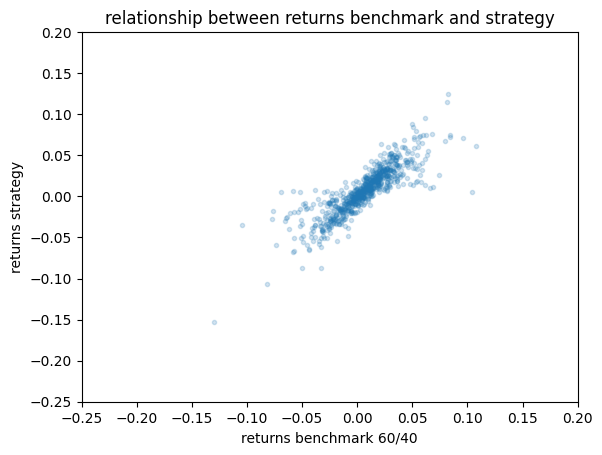

In [14]:

#Explore relationship between benchmark returns and strategy returns
plt.plot(strat_df['bench_tr'],strat_df['strat_nr'],'o',alpha=0.2,markersize=3)
plt.title('relationship between returns benchmark and strategy')
plt.xlabel('returns benchmark 60/40')
plt.ylabel('returns strategy')
plt.axis([-0.25,0.2,-0.25,0.2])


#simple regression
res=ss.linregress(strat_df['bench_tr'],strat_df['strat_nr'])
print(res)
res.slope




In [15]:
#correlation matrix of returns different assets
strat_df[['strat_nr','lei_return','oecd_diffusion_return','oecd_return','sahm_return','yield_curve_return','bench_tr']].corr()


,strat_nr,lei_return,oecd_diffusion_return,oecd_return,sahm_return,yield_curve_return,bench_tr
strat_nr,1.000000,0.932813,0.765740,0.828196,0.897964,0.859658,0.857056
lei_return,0.932813,1.000000,0.661842,0.689052,0.821246,0.799423,0.792881
oecd_diffusion_return,0.765740,0.661842,1.000000,0.630445,0.591670,0.530062,0.540836
oecd_return,0.828196,0.689052,0.630445,1.000000,0.681575,0.588262,0.634302
sahm_return,0.897964,0.821246,0.591670,0.681575,1.000000,0.708086,0.842619
yield_curve_return,0.859658,0.799423,0.530062,0.588262,0.708086,1.000000,0.812354
bench_tr,0.857056,0.792881,0.540836,0.634302,0.842619,0.812354,1.000000
